<a href="https://colab.research.google.com/github/Mollylst/DeepFake-Project/blob/main/CIFAR_10_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Load the database and do preprocessing.
2. The preprocessed data is divided into two parts: feature and label. Feature is sent to the model, and label is regarded as ground truth.
3. Mode accepts features as inputs, and outputs predict through a series of calculations.
4. Establish a loss function by using predict as a variable. The function value of loss represents the gap between predict and ground truth.
5. Establish an optimize optimizer. The goal of optimization is the loss function, and its value is as small as possible. The smaller the loss, the higher the accuracy of the model.
6. During the optimization process of the optimizer, the model changes the weights of its own parameters according to the rules, and iteratively loops until the loss is close to stable and can no longer get a smaller value.

In [ ]:
import torch
import torchvision  #torchvision has data loaders for common datasets
import torchvision.transforms as transforms #Commonly used image operations, such as random cutting, rotation, data type conversion, exchange to tensor, numpy or PIL Image

########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].
########################################################################
#The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size

# Preprocess the data, the default image format is numpy, so it is converted to tensor through transforms
transform = transforms.Compose(
    [transforms.ToTensor(), # ToTensor() works for the image, whose elements are in range 0 to 255. ToTensor() can transform the gray scale from 0-255 to 0-1, 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #transform.Normalize() transforms 0-1 to (-1,1). For each channel,image=(image-mean)/std
                                    #0-1 The minimum value 0 becomes (0-0.5)/0.5=-1, and the maximum value 1 becomes (1-0.5)/0.5=1

batch_size = 25 # The number of samples selected for one training, its size affects the optimization degree and speed of the model
         # When batch size is not used. It is to enter all the data (the entire database) into the network at once，GPU is not enough

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
#'root': the location of the dataset, download the training data

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
#The dataset needs dataloader, it continuously extract data from the dataset and send it to the model for training and prediction.
#The number of extracted images in a single batch is batch size, and sheffle=true means that the order is randomly shuffled when extracting data.
#num—workers is the number of worker threads

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
#There is no need to update the parameters during the test, so there is no need to shuffle

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


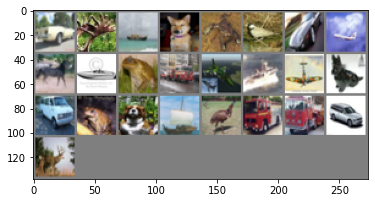

  car  deer  ship   dog  frog  bird   car plane horse  ship  frog truck plane  ship plane   dog   car  frog   dog  ship  bird truck truck   car  deer


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #np.transpose function, convert the data format of npimg from (channels,imagesize,imagesize) to (imagesize,imagesize,channels), and display it after the format conversion
    plt.show()

# get some random training images
dataiter = iter(trainloader) #The iter() function is used to generate iterators.
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


1.In PyTorch, the neural network can be defined by inheriting nn.Modeule, the structure is set in init(), and the forward propagation process is set in forward.

2.The pooling layer is generally followed by the convolutional layer to simplify the output result of the convolution. In fact, the output result of the convolutional layer is compressed.

3.The fully connected layer functions as a "classifier" in the entire convolutional neural network, that is, after deep networks such as convolution, relu function, and pooling, the results are identified and classified through the fully connected layer. First, the convolution and pooling results are stringed together to obtain the weight of the fully connected layer, and the predicted value of each result is obtained, and then the largest value is used as the recognition result.

4.The relu layer retains the value greater than 0, that is, retains the better value of the feature, and discards the value of the feature less than 0. f(x)=max(0,x)

In [ ]:
########################################################################
# 2. Define a Convolutional Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Copy the neural network from the Neural Networks section before and modify it to
# take 3-channel images (instead of 1-channel images as it was defined).

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module): 
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) #(input featurs:input image channels, output features:output image channels, size of kernal:3x3 convolution kernal)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, stride=2) 
        self.bn1 = nn.BatchNorm2d(32) #Add BatchNorm2d to normalize the data, so that the data will not cause network performance instability due to excessive data before Relu.
        self.relu1 = nn.ReLU()

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, stride=2) 
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()

        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, stride=2) 
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        self.fc1 = nn.Linear(128 * 4 * 4, 512) 
        self.drop1 = nn.Dropout2d() #When we propagate forward, let the relu value of a certain neuron stop working with a certain probability, which can make the model more generalized, because it will not rely too much on some local features
        self.fc2 = nn.Linear(512, 120)
        self.drop2 = nn.Dropout2d()
        self.fc3 = nn.Linear(120, 10)
        #######################
        #The number of input features of the linear layer is defined by the activation size from the previous layer. 
        #[batch_size, channels= 16, height= 5, width= 5]. In order to pass this activation to nn.Linear, this tensor needs to be flattened to [batch_size, 16 * 5 * 5]. 16 is defined by the number of out_channels, 5x5 is the space size defined by conv and the pooling operation performed on the input data.

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv5(x)
        x = self.conv6(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        #x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        #x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = x.view(-1,128*4*4)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(net.parameters(),lr=0.0001)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #learning rate
                                   #momentem: correct value of momentum is obtained by cross validation and would avoid getting stuck in a local minima.

The difference between epoch and iteration:
iteration refers to a single mini-batch training.
For example, the number of images in CIFAR-10 dataset is 50000, the size of batch size is 100, then it needs 500 times iteration, then can walk through one epoch.


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

net.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

In [ ]:
########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize.

for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

         # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

#50000/batch_size(25)=2000

[1,  2000] loss: 1.598
[2,  2000] loss: 1.068
[3,  2000] loss: 0.868
[4,  2000] loss: 0.754
[5,  2000] loss: 0.669
[6,  2000] loss: 0.596
[7,  2000] loss: 0.544
[8,  2000] loss: 0.489
[9,  2000] loss: 0.449
[10,  2000] loss: 0.401
[11,  2000] loss: 0.366
[12,  2000] loss: 0.339
[13,  2000] loss: 0.311
[14,  2000] loss: 0.277
[15,  2000] loss: 0.259
Finished Training


In [ ]:
########################################################################
# Let's quickly save our trained model:

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
########################################################################

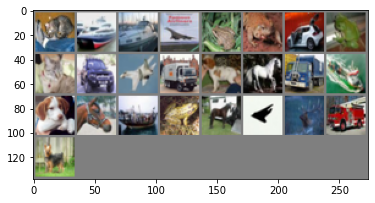

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car
Predicted:    cat  ship  ship plane  frog  frog   car  frog   cat   car
Accuracy of the network on the 10000 test images: 79 %


In [ ]:
# Test the network on the test data
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

########################################################################
# Next, let's load back in our saved model (note: saving and re-loading the model
# wasn't necessary here, we only did it to illustrate how to do so):

net = Net()
net.load_state_dict(torch.load(PATH))

########################################################################
# Okay, now let us see what the neural network thinks these examples above are:

outputs = net(images)

########################################################################
# The outputs are energies for the 10 classes.
# The higher the energy for a class, the more the network
# thinks that the image is of the particular class.
# So, let's get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(10)))

########################################################################
# The results seem pretty good.
#
# Let us look at how the network performs on the whole dataset.

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item() #sum of the correct prediction

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 79.1 %
Accuracy for class car   is: 87.4 %
Accuracy for class bird  is: 73.0 %
Accuracy for class cat   is: 58.0 %
Accuracy for class deer  is: 74.1 %
Accuracy for class dog   is: 75.8 %
Accuracy for class frog  is: 82.6 %
Accuracy for class horse is: 86.4 %
Accuracy for class ship  is: 90.8 %
Accuracy for class truck is: 86.6 %
